In [1]:
import glob
import os
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import yaml
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import stats

plt.style.use(["science", "nature"])
import pickle

plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 5
plt.rcParams['hatch.linewidth'] = 0.5

protocol_map = {
    "Visium": "10X Visium",
    "VisiumHD": "10X Visium HD",
    "Chromium": "10X Chromium",
    "Dropseq": "Drop-seq",
    "Stereoseq": "Stereo-seq",
    "Slideseq": "Slide-seq V2",
    "SpatialTranscriptomics": "ST",
    "Microwell": "Microwell-seq",
    "annotation": "Annotated PAS",
    "Annotation": "Annotated PAS",
}

order = ["10X Chromium", "Drop-seq", "Microwell-seq", "10X Visium","Stereo-seq", "Slide-seq V2", "ST"]

color = [
    "#386b98",
    "#269a51",
    "#edaa4d",
    "#d34123",
    "#7e648a",
    "#454545",
    "#929292",
]
palette=sns.color_palette(color, 7)
mm = 1/25.4

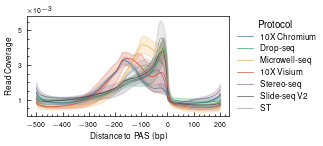

In [2]:
# fig2b
cov_path = "/root/apabenchmark/data/raw_bam_feature/pas_cov/pas_500_cov.csv"
cov_df = pd.read_csv(cov_path)
cov_df["protocol"] = cov_df["protocol"].map(protocol_map)

fig, ax = plt.subplots(figsize=(85*mm, 40*mm))

for i, protocol in enumerate(order):
    subset_df = cov_df[cov_df["protocol"] == protocol]
    color=palette[i]
    sns.lineplot(x="position", y="cov", label=protocol,
                 data=subset_df, ax=ax, alpha=0.9, errorbar="sd", color=color, linewidth=0.5)

ax.set_xlabel("Distance to PAS (bp)")
ax.set_ylabel("Read Coverage")
ax.tick_params(which='both', top=False, right=False)
ax.legend(title="Protocol", fontsize=6, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yticks([0.001, 0.003, 0.005])
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
fig.tight_layout()
# plt.savefig("../../figures/fig2b.pdf", dpi=300, bbox_inches="tight")

In [3]:
# fig2c, d
params_pickle_list = glob.glob("/root/apabenchmark/data/peak_params/*.pkl")
coverage_dict = {}
params_df = pd.DataFrame()
for i, pickle_file in tqdm(enumerate(params_pickle_list)):
    with open(pickle_file, "rb",) as f:
        coverage, dist_df = pickle.load(f)
    protocol = pickle_file.split("/")[5].split("_")[0]
    coverage_dict[pickle_file] = coverage
    dist_df["protocol"] = protocol_map[protocol]
    dist_df["sample"] = "_".join(pickle_file.split("/")[-1].split("_")[0:4])
    params_df = pd.concat([params_df, dist_df])


params_df["protocol"] = pd.Categorical(params_df["protocol"], categories=order, ordered=True)
params_df = params_df.sort_values("protocol").reset_index(drop=True)

iodt_counts_list = glob.glob("/root/apabenchmark/data/raw_bam_feature/iodt/*.counts")
with open('/root/apabenchmark/data/raw_bam_feature/read_length/sample.yaml', 'r') as file:
    read_length_dict = yaml.safe_load(file)

raw_data_feature_dict = {}
for i, ic in enumerate(iodt_counts_list):
    iodt_count = int(open(ic).readlines()[0].strip())
    read_count = int(open(ic).readlines()[-1].strip())
    sample = ic.split("/")[-1].split(".")[0]
    protocol = ic.split("/")[-1].split("_")[0]
    raw_data_feature_dict[sample] = {
            "protocol": protocol_map[protocol],
            "iodt_count": iodt_count,
            "read_count": read_count,
    }

apex_position_std = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Max_Cov"].std().rename("apex_position_std")).reset_index()
kurtosis_std = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Kurtosis"].std().rename("kurtosis_std")).reset_index()
apex_position_mean = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Max_Cov"].mean().rename("apex_position_mean")).reset_index()
kurtosis_mean = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Kurtosis"].mean().rename("kurtosis_mean")).reset_index()
apex_position_mean["apex_position_mean"] = apex_position_mean["apex_position_mean"] 
kurtosis_median = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Kurtosis"].median().rename("kurtosis_median")).reset_index()
apex_position_median = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Max_Cov"].median().rename("apex_position_median")).reset_index()
apex_position_median["apex_position_median"] = apex_position_median["apex_position_median"]
peak_size_median = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Peak_Size"].median().rename("peak_size_median")).reset_index()
peak_size_mean = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Peak_Size"].mean().rename("peak_size_mean")).reset_index()
peak_size_std = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Peak_Size"].std().rename("peak_size_std")).reset_index()
edge_position_std = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Min_Dist"].std().rename("edge_position_std")).reset_index()
edge_position_mean = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Min_Dist"].mean().rename("edge_position_mean")).reset_index()
edge_position_median = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Min_Dist"].median().rename("edge_position_median")).reset_index()
skewness_median = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Skewness"].median().rename("skewness_median")).reset_index()
skewness_mean = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Skewness"].mean().rename("skewness_mean")).reset_index()
skewness_std = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Skewness"].std().rename("skewness_std")).reset_index()
peak_height_median = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Peak_Height"].median().rename("peak_height_median")).reset_index()
peak_height_mean = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Peak_Height"].mean().rename("peak_height_mean")).reset_index()
peak_height_std = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Peak_Height"].std().rename("peak_height_std")).reset_index()

raw_data_feature_df = pd.DataFrame(raw_data_feature_dict).T.reset_index(names="sample").sort_values(["protocol"])
raw_data_feature_df = raw_data_feature_df.merge(pd.DataFrame(read_length_dict["raw_sample"]).T.reset_index(names="sample"))
raw_data_feature_df = pd.merge(raw_data_feature_df, apex_position_mean, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, apex_position_std, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, kurtosis_mean, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, kurtosis_std, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, apex_position_median, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, kurtosis_median, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, peak_size_median, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, peak_size_mean, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, peak_size_std, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, edge_position_mean, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, edge_position_std, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, edge_position_median, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, skewness_mean, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, skewness_std, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, skewness_median, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, peak_height_mean, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, peak_height_std, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, peak_height_median, on=["sample", "protocol"])


28it [00:14,  1.87it/s]


/tmp/ipykernel_1514881/1834613498.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)


ValueError: Could not interpret value `peak_variance` for `x`. An entry with this name does not appear in `data`.

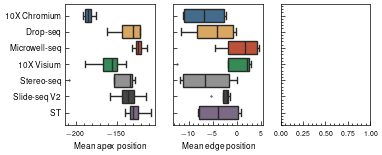

In [4]:
plt.close()
fig, axs = plt.subplots(
    1, 3, figsize=(100*mm,40*mm),sharey=True
)

feature_list = [
    "apex_position_mean",
    "edge_position_mean",
    "peak_variance",
    ]
feature_label_map = {
    "peak_height_mean": "Mean peak height",
    "apex_position_mean": "Mean apex position",
    "edge_position_std": "Edge position SD",
    "kurtosis_mean": "Mean Kurtosis",
    "apex_position_std": "Apex position SD",
    "edge_position_mean": "Mean edge position",
    "kurtosis_std": "Kurtosis SD",
    "peak_height_std": "Peak height SD",
    "skewness_mean": "Mean skewness",
    "skewness_std": "Skewness SD",
    "peak_variance": "Peak variance",
    "peak_consistency": "Peak consistency",
}

for i, feature in enumerate(feature_list):
    ax = axs[i]
    sns.boxplot(
        data=raw_data_feature_df,
        y="protocol",
        x=feature,
        order=order,
        palette=palette,
        hue="protocol",
        legend=False,
        ax=ax,
        fliersize=0.5,
    )
    ax.set_xlabel(feature_label_map[feature],fontsize=6)
    ax.tick_params(which="both", top=False, right=False)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.tick_params(which="minor", left=False)
    if i == 0 :
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
        ax.set_ylabel("")
    ax.set_ylim([ax.get_ylim()[0]+0.3, ax.get_ylim()[1]-0.2])
plt.tight_layout()
plt.subplots_adjust(wspace=0.02, bottom=0.2)
# plt.savefig("../../figures/fig2/fig2c.pdf", bbox_inches='tight',dpi=300)

In [ ]:
plt.close()
fig, ax = plt.subplots(
    1, 1, figsize=(70*mm,40*mm),sharey=True
)
sns.scatterplot(
    data=raw_data_feature_df,
    x="kurtosis_mean",
    y="skewness_mean",
    hue="protocol",
    hue_order=order,
    palette=palette,
    s=15,
    ax=ax
)
ax.set_xlabel(feature_label_map["kurtosis_mean"],fontsize=6)
ax.set_ylabel(feature_label_map["skewness_mean"],fontsize=6)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6)
ax.axvline(3, color="red", linestyle="--")
ax.axhline(0, color="red", linestyle="--")
ax.set_yticks([-0.6, -0.4, -0.2, 0])
plt.tight_layout()
plt.savefig("../../figures/fig2/fig2d.pdf", bbox_inches='tight',dpi=300)